# Clustered Federated Learning to Support Context-dependent CSI Decoding

### Introduction
In this Jupyter Notebook, we explore various heterogeneous channel distributions and their impact on training and designing CSI compressors (autoencoders). Channel heterogeneity poses a challenge for efficient training because a single global CSI autoencoder may fail to utilize the codeword (latent) space effectively across diverse channel conditions.

To address this issue, this tutorial demonstrates how to use **Clustered Federated Learning (CFL)** to train **Context-dependent decoders**. Specifically, we cluster the heterogeneous channel datasets based on gradient similarity and train separate decoders for each cluster.

After completing the training, we analyze the results.

### CSI

We consider a system with **32 Base Station (BS) antennas** and **1 User Equipment (UE) antenna**, operating over **256 subcarriers**. Each CSI instance is represented as a **32 × 256 complex matrix** in the **Spatial-Frequency (SF) domain**.
To reduce computational complexity, we transform the CSI to the **Angular-Delay (AD) domain** using a **2D Inverse Fast Fourier Transform (2D-IFFT)**. This transformation often results in a sparse representation, making it more efficient for processing.

Let's visualize how these representations look.

In [1]:
from data.dataset_loader.wireless_channel_distributions_loader import WirelessChannelDistributions, sample_visualization_wireless_channel_distributions
import importlib
dataset = WirelessChannelDistributions(normalization=False)

dataset variance: 8.770762588428127e-11


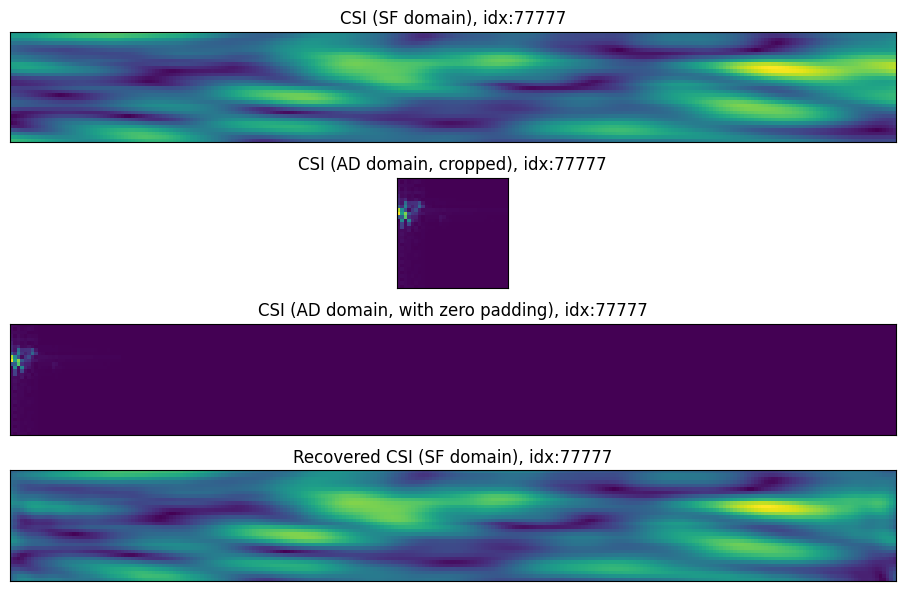

In [2]:
sample_visualization_wireless_channel_distributions(dataset, indices=[77777])

### CSI Preprocessing and Representation

In the above visualizations, we illustrate four different representations of CSI:

1. **Original CSI (Spatial-Frequency Domain):**  
   - The first image (top) represents the original CSI matrix of size **32 × 256** in the spatial-frequency domain.

2. **Angular-Delay Domain Transformation (Cropped CSI):**  
   - By applying a **2D Inverse Fast Fourier Transform (2D-IFFT)**, we transform the CSI into the angular-delay domain.  
   - Since the high-delay region contains near-zero values, we crop this region, resulting in a **32 × 32** matrix (second image).

3. **Zero-Padded CSI in Angular-Delay Domain:**  
   - In the third image, we extend the cropped CSI by adding a **zero matrix** on the right-hand side, restoring the original width.

4. **Reconstructed CSI (Spatial-Frequency Domain):**  
   - By applying a **2D FFT** to the zero-padded matrix, we obtain the final CSI representation.  
   - The original (top) and the reconstructed (bottom) representations appear nearly identical.

This method is widely used in various existing learning-based CSI feedback approaches. Throughout this work, we consider the **cropped angular-delay domain CSI (second image)** as the ground-truth CSI sample and focus on its compression.

### Heterogeneous Channel State Information Datasets

In real-world scenarios, channel distributions vary due to factors such as device configurations (e.g., UE and BS), wireless channel environments, frequency bandwidth, and other conditions. These variations introduce **heterogeneity**, which can impact the performance of CSI feedback compressors. 

On the one hand, different channel distributions may exhibit distinct characteristics, making it inefficient to handle all of them by a single global model. On the other hand, some of them may also share certain similarities, which can be leveraged for more efficient learning.

To capture this diversity, our dataset consists of **eight different channel distribution datasets**, each representing a unique scenario. Let's explore their characteristics.


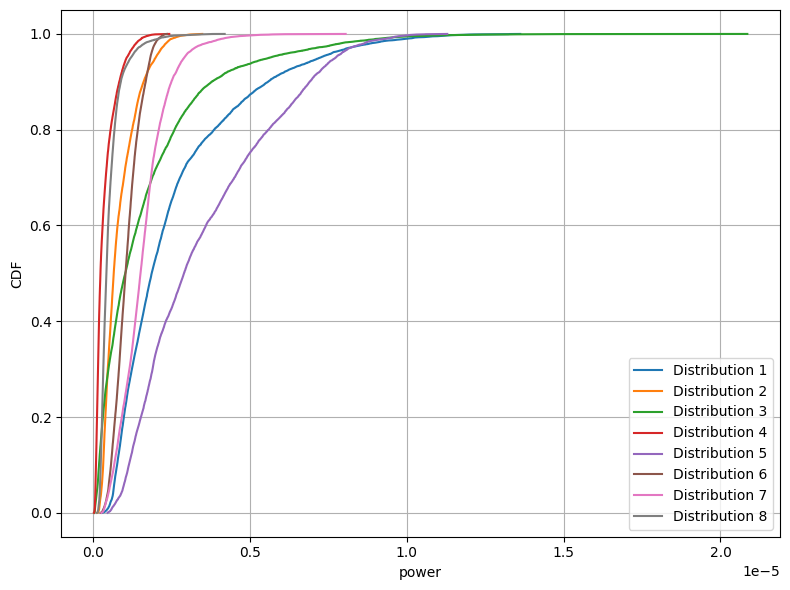

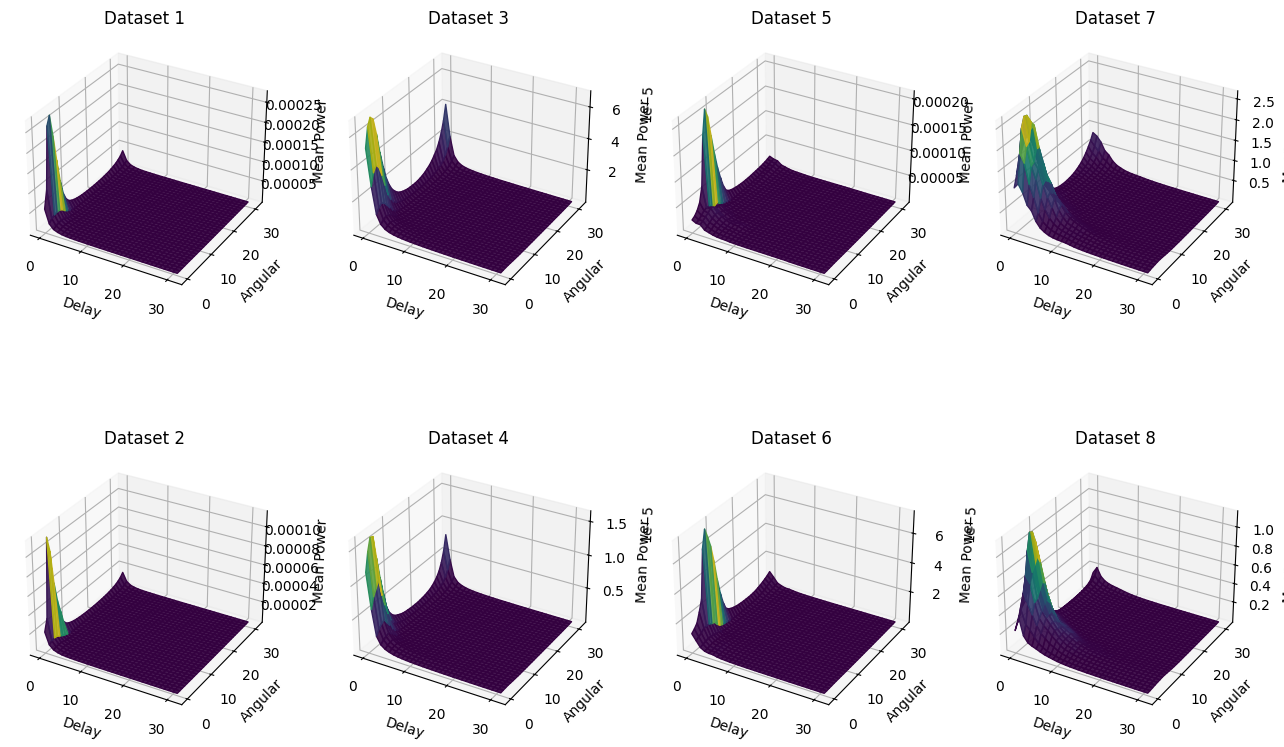

In [3]:
from data.dataset_loader import wireless_channel_distributions_loader
importlib.reload(wireless_channel_distributions_loader)
from data.dataset_loader.wireless_channel_distributions_loader import distribution_visualization_wireless_channel_distributions
distribution_visualization_wireless_channel_distributions(dataset)

The first figure presents the cumulative distribution function (CDF) of channel power for each data distribution. The second figure illustrates the average power spectral density over the delay-angular domain, where color represents variance across different data distributions.

## Challenges in Heterogeneous Channel Environments

These heterogeneous channel environments introduce several real-world challenges:

- **(a)** The need to efficiently accommodate diverse channel conditions across varying contexts (e.g., environments) and determine whether to use multiple encoder/decoders.
- **(b)** The cost of gathering sufficient data to train neural network models across various contexts.
- **(c)** The need to protect sensitive data regarding competing providers’ coverage.

## Proposed Framework

To address these challenges, we propose a framework that utilizes a **single universal encoder with context-dependent decoders**. To limit the number of decoders, we introduce a **clustering approach** that groups similar contexts to share the same decoder. 

We employ a **clustered federated learning (CFL) algorithm**, which simultaneously:
- Learns context clusters and models.
- Leverages distributed datasets without requiring direct access to raw data, effectively addressing both **(b) and (c)**.

CFL-GP, our proposed CFL algorithm, jointly clusters contexts and optimizes the encoder along with context-cluster-dependent decoders using distributed data. Clustering is performed based on the similarity of time-averaged gradients across different contexts.

In [4]:
%run main.py --algorithm CFLGP --random_seed 0 --model VQCINet256 --dataset wireless_channels --load --test

2025-04-15 16:36:10.028280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 16:36:10.028315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 16:36:10.029834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 16:36:10.039965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 16:36:11.134296: W tensorflow/comp

dataset variance: 0.0005792547017335892
dataset variance: 0.0005769020644947886


n_params_per_model:400363
n_params_compressed_gradient:400363
Load encoder model success
Load model success
100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


### Data analysis
The project automatically stores the results in the `ROOT_DIRECTORY`. You can retrieve the experiment results from this location.

In [5]:
from global_config import ROOT_DIRECTORY
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.join(ROOT_DIRECTORY, "results", "wireless_channels")
data_dir_CFLGP = os.path.join(base_dir, "CFLGP_model_averaging_VQCINet256_vqvae_compression_b200_nc8_seed0", "data_tracking", "metrics.pickle")


#### Visualization of gradient profile matrix $G$ from CFL-GP
The context clustering is based on the gradient profile matrix $G$, which captures the accumulated gradient information across multiple models for each context. This matrix serves as the foundation for identifying context clusters in the proposed method. As shown below, the eight distinct contexts are grouped into four clusters.

(3, 8)
training iterations: 1000, number of models: 3, number of clients: 8


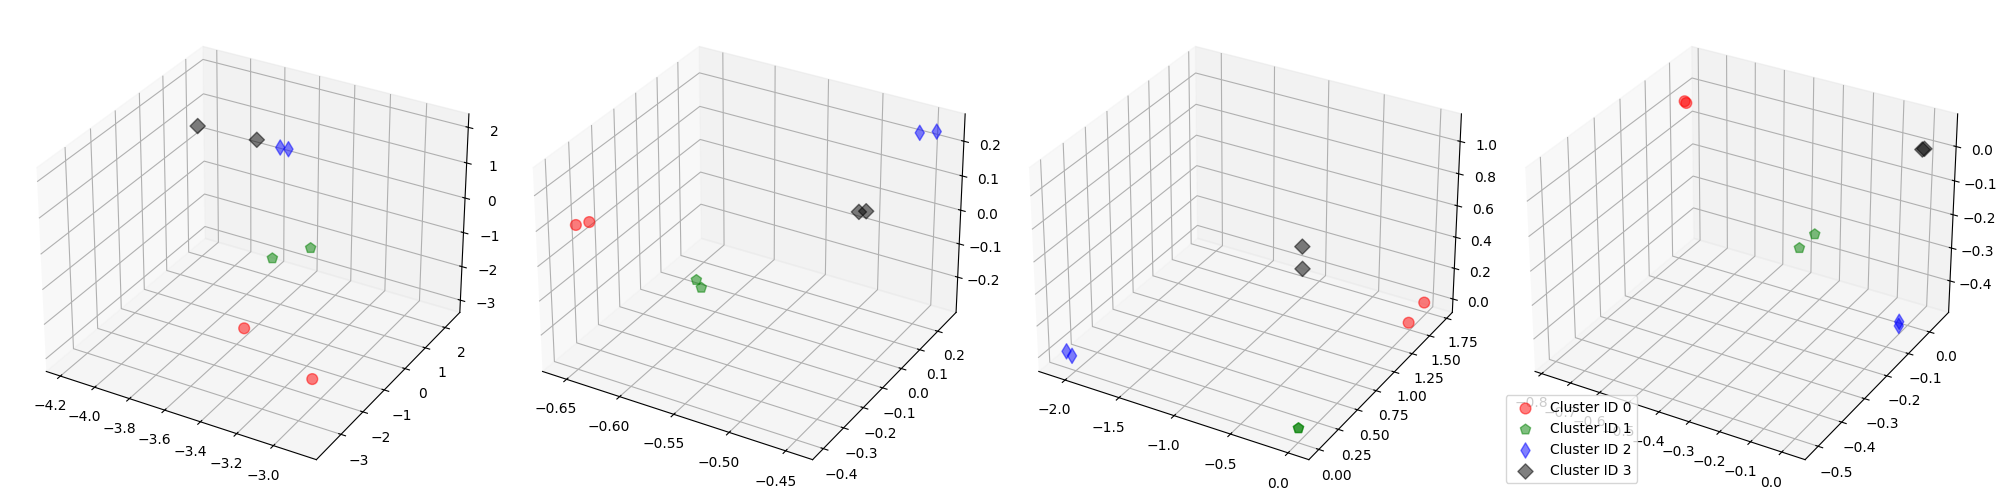

In [6]:
from data.visualization_utils import get_gradient_profile_matrix, get_average_performance_vector


gradient_profile_matrices = get_gradient_profile_matrix(data_dir_CFLGP)
gradient_profile_matrices = [x for x in gradient_profile_matrices if x is not None]
print(gradient_profile_matrices[0].shape)
num_iter = len(gradient_profile_matrices)
n_models, n_clients = gradient_profile_matrices[0].shape
total_n_clusters = 4
markers = ['o', 'p', 'd', 'D']
colors = ['r', 'g', 'b', 'k']
print("training iterations: {}, number of models: {}, number of clients: {}".format(num_iter, n_models, n_clients))


# Random projection to 3-D space
#random_projection_matrix = np.random.random((3, n_models))
#gradient_profile_matrices = [np.matmul(random_projection_matrix, gradient_profile_matrix) for i, gradient_profile_matrix in enumerate(gradient_profile_matrices) if i <6]

# Create figure and axes
fig = plt.figure(figsize=(20, 10))

# Define positions manually
axes = []
for i in range(4):
    if i < 4:
        ax = fig.add_subplot(2, 4, i + 1, projection='3d')  # First row: 4 plots
    else:
        ax = fig.add_subplot(2, 2, i - 3 + 5, projection='3d')  # Second row: 2 plots (5,6 positions)
    axes.append(ax)

for i, time_step in enumerate([0, 2, 4, 6]):
    projected_G = gradient_profile_matrices[time_step].T
    ax = axes[i]
    for cluster_id in range(total_n_clusters):
        ax.scatter(
            projected_G[cluster_id * (n_clients // total_n_clusters):(cluster_id + 1) * (n_clients // total_n_clusters), 0],
            projected_G[cluster_id * (n_clients // total_n_clusters):(cluster_id + 1) * (n_clients // total_n_clusters), 1],
            projected_G[cluster_id * (n_clients // total_n_clusters):(cluster_id + 1) * (n_clients // total_n_clusters), 2],
            s=60, marker=markers[cluster_id], color=colors[cluster_id],
            label=f"Cluster ID {cluster_id}", alpha=0.5
        )
    if i == 3:
        ax.legend(loc='lower left')

plt.tight_layout()
plt.show()


#### Performance analysis
Additionally, we can extract the clients' average performance from the stored results and visualize it as follows.

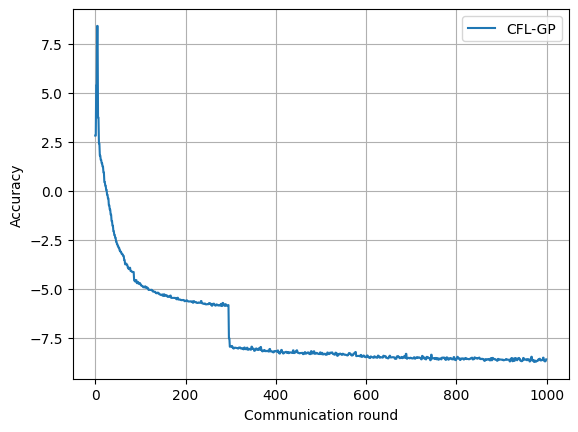

In [7]:
performance_CFLGP = get_average_performance_vector(data_dir_CFLGP)
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(performance_CFLGP)), performance_CFLGP, label="CFL-GP")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Communication round")
ax.legend()
ax.grid()
plt.show()
